### Análise e identificação de SPAM em mensagens

#### *Situação Problema* 

Uma operadora de telecomunicações está recebendo reclamações de clientes sobre mensagens de spam em seus celulares. Essas mensagens não só irritam os usuários, mas também podem levar a golpes financeiros. A empresa contratou sua equipe para desenvolver um modelo de classificação automática que identifique mensagens spam com alta precisão, evitando bloquear mensagens legítimas (especialmente alertas importantes, como notificações bancárias ou emergenciais).

Objetivo: Criar um modelo de machine learning que classifique SMS como ham ou spam com base no conteúdo textual.

In [3]:
!pip install nltk

In [4]:
#Importando libraries
import pandas as pd
import re # ferramentas para procurar e manipular textos com padrões.
import nltk
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

#### 1. Carregamento e exploração inicial

In [ ]:
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



##### Ham vs. Spam

Ham = mensagens normais e úteis

Spam = mensagens indesejadas, como propagandas, golpes ou notificações invasivas.



In [6]:
# Contar quantas mensagens são ham e quantas são spam

df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [7]:
# Verificar exemplos de mensagens de cada classe (5)

# Exemplo mensagens 'ham'
print("Mensagens HAM:")
print(df[df['label'] == 'ham']['message'].head(), "\n")

# Exemplo mensagens 'Spam'
print("Mensagens SPAM:")
print(df[df['label'] == 'spam']['message'].head())

Mensagens HAM:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: message, dtype: object 

Mensagens SPAM:
2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: message, dtype: object


#### 2. Pré-processamento de texto


In [8]:
# Limpar o texto: remover caracteres especiais, números e converter para minúsculas.

def limpar_texto(texto):
    texto = texto.lower()  # converte para minúsculas
    texto = re.sub(r'[^a-z\s]', '', texto)  # remove números e caracteres especiais
    texto = re.sub(r'\s+', ' ', texto).strip()  # remove espaços duplicados e espaços no início/fim
    return texto

# Aplicar a função de limpeza à coluna 'message'
df['mensagem_limpa'] = df['message'].apply(limpar_texto)

df[['message', 'mensagem_limpa']].head()

,message,mensagem_limpa
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [9]:
##### Tokenizar as mensagens (dividir o texto em pedaços menores)

df['tokens'] = df['mensagem_limpa'].apply(lambda x: x.split())

# Exibir as colunas: original, limpa e tokens
df[['mensagem_limpa', 'tokens']].head()

,mensagem_limpa,tokens
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [10]:
nltk.download('punkt')

df['tokens'] = df['mensagem_limpa'].apply(word_tokenize)
df[['mensagem_limpa', 'tokens']].head()

[nltk_data] Downloading package punkt to C:\Users\Caio
[nltk_data]     Bello\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


,mensagem_limpa,tokens
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [11]:
# Baixar as stopwords
nltk.download('stopwords')  # Baixa lista de stopwords

[nltk_data] Downloading package stopwords to C:\Users\Caio
[nltk_data]     Bello\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
# Stopwords em inglês
stopwords_en = set(stopwords.words('english'))

In [13]:
# Função para filtrar as stopwords de cada lista de tokens
def remover_stopwords(tokens):
    return [palavra for palavra in tokens if palavra not in stopwords_en]

# Aplicar a função
df['tokens_sem_stopwords'] = df['tokens'].apply(remover_stopwords)

# Visualizar o resultado
df[['mensagem_limpa', 'tokens', 'tokens_sem_stopwords']].head()


,mensagem_limpa,tokens,tokens_sem_stopwords
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."


#### 3. Vetorização dos Dados

##### Converter texto em features numéricas usando TF-IDF ou Bag of Words.


Bag of Words pode dar pesos iguais a todas as palavras, mesmo aquelas que não são tão informativas.

TF-IDF geralmente funciona melhor em tarefas de classificação de texto, pois ele destaca as palavras mais relevantes para distinguir entre as classes.

* Considerando que nosso objetivo é classificar mensagens como spam ou ham, o TF-IDF tende a ser uma escolha mais eficaz.
  

In [14]:

# Inicializar o vetorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Ajustar o vetorizador aos tokens (para criar o vocabulário)
tfidf_vectorizer.fit(df['tokens_sem_stopwords'].apply(lambda x: ' '.join(x)))

# Transformar os tokens em vetores TF-IDF
tfidf_vectors = tfidf_vectorizer.transform(df['tokens_sem_stopwords'].apply(lambda x: ' '.join(x)))

print("Formato da matriz TF-IDF:", tfidf_vectors.shape)

Formato da matriz TF-IDF: (5572, 8476)


#### 4. Divisão dos Dados


In [15]:
# Separar o dataset em conjuntos de treino (70%) e teste (30%)

# Features
X = tfidf_vectors

# Rótulos
y = df['label']

# Divisão em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Visualizar distribuição original das classes no treino
print("Distribuição original no treino:")
print(pd.Series(y_train).value_counts())

# Aplicando SMOTE para balancear os dados no conjunto de treino

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualizar distribuição após o balanceamento
print("\nDistribuição após SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Distribuição original no treino:
label
ham     3377
spam     523
Name: count, dtype: int64

Distribuição após SMOTE:
label
spam    3377
ham     3377
Name: count, dtype: int64


##### O conjunto de treino tinha desequilíbrio entre as classes:

ham: 3.377 mensagens (mensagens legítimas)

spam: 523 mensagens (mensagens indesejadas)

O SMOTE (Synthetic Minority Over-sampling Technique) foi aplicado, criando exemplos sintéticos da classe minoritária (spam) até que ela tivesse a mesma quantidade de exemplos que a classe majoritária

### 5. Treinamento de Modelos e 6. Avaliação dos modelos

#### (Os testes e avaliações dos modelos foram desenvolvidos na mesma etapa)

##### *SVM LINEAR*

In [16]:
# SVM Linear

# Treinar o modelo com os dados balanceados
modelo_svm = LinearSVC()
modelo_svm.fit(X_train_resampled, y_train_resampled)

# Previsões com os dados de teste
y_pred = modelo_svm.predict(X_test)

# Relatório de classificação
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))



Acurácia: 0.9838516746411483

Relatório de Classificação:

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.98      0.90      0.94       224

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



c:\Users\Caio Bello\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


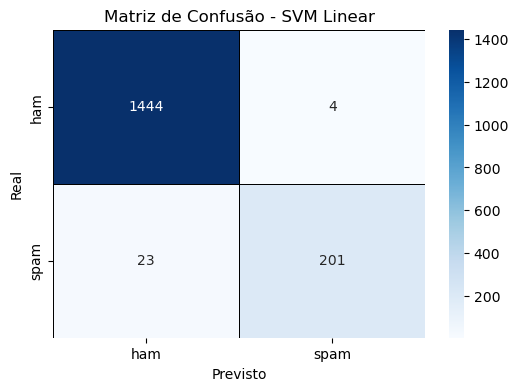

In [17]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'],
            linewidths=.5, linecolor='black') # Adicionando linewidths e linecolor
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - SVM Linear')
plt.show()

##### Interpretação:

* Acurácia: O modelo classificou corretamente 98.38% de todas as mensagens no conjunto de teste.

---------------------------------

* Verdadeiros Positivos (spam bem classificados): 202
* Verdadeiros Negativos (ham bem classificados): 1444
* Falsos Positivos (ham classificados como spam): 4
* Falsos Negativos (spam classificados como ham): 22

##### Resumo

* Precisão (Precision): das mensagens classificadas como spam, 98% realmente eram spam.

* Recall (De todas as mensagens que realmente eram spam, quantas o modelo conseguiu encontrar?): o modelo encontrou 90% dos spams 

* F1-Score (equilíbrio entre precisão e recall): 0.94 para spam

O modelo SVM Linear demonstrou um bom equilíbrio entre precisão e recall na detecção de spam. Ele apresenta uma alta precisão (98%), garantindo que a maioria das mensagens classificadas como spam sejam realmente spam, e um recall de 90%, indicando que ele detecta a grande maioria dos spams reais. A acurácia geral do modelo é alta, refletindo um desempenho robusto em ambas as classes.

##### *NAIVE BAYES MULTINOMIAL*

In [20]:
# Treinar o modelo
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Previsão com os dados de teste
y_pred_nb = nb_model.predict(X_test)

# Relatório de classificação
print("Acurácia:", accuracy_score(y_test, y_pred_nb))
print("Relatório de Classificação - Naive Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=['ham', 'spam']))

Acurácia: 0.9623205741626795
Relatório de Classificação - Naive Bayes:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       1.00      0.72      0.84       224

    accuracy                           0.96      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.96      0.96      0.96      1672



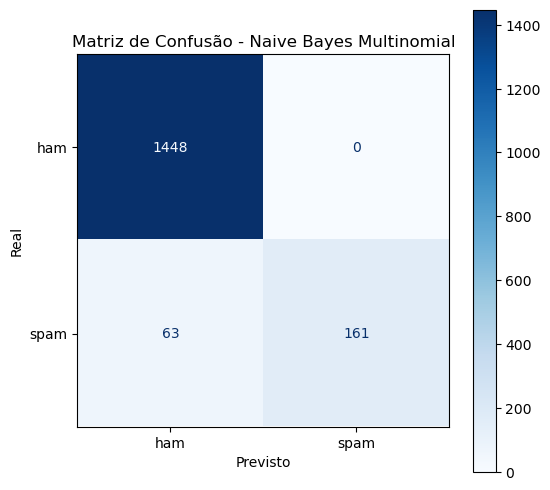

In [21]:
# Matriz de confusão - Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['ham', 'spam'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Matriz de Confusão - Naive Bayes Multinomial")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

##### Interpretação:

* Acurácia: O modelo classificou corretamente 96.23% de todas as mensagens no conjunto de teste.

---------------------------------

* Verdadeiros Positivos (spam bem classificados): 161
* Verdadeiros Negativos (ham bem classificados): 1448
* Falsos Positivos (ham classificados como spam): 0
* Falsos Negativos (spam classificados como ham): 63

##### Resumo:

* Precisão (Precision) para spam: Das mensagens classificadas como spam, 100% realmente eram spam.

* Recall (De todas as mensagens que realmente eram spam, quantas o modelo conseguiu encontrar?): O modelo encontrou 72% dos spams.
  
* F1-Score (equilíbrio entre precisão e recall para spam): 0.84 para spam.

Em resumo, o modelo Naive Bayes Multinomial apresenta uma precisão perfeita para a detecção de spam, o que significa que quando ele identifica uma mensagem como spam, é muito provável que ela realmente seja. No entanto, o recall para spam é de 72%, indicando que o modelo deixa de identificar uma parte das mensagens de spam reais. O desempenho para a classe 'ham' é muito bom, com precisão e recall elevados. A acurácia geral do modelo é de 96%.

##### *RANDOM FOREST ou REGRESSÃO LOGÍSTICA*

In [22]:
# Treinar o modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Previsão com os dados de teste
y_pred_rf = rf_model.predict(X_test)

# Relatório de classificação
print("\nAcurácia - Random Forest:", accuracy_score(y_test, y_pred_rf))
print("\nRelatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['ham', 'spam']))



Acurácia - Random Forest: 0.9784688995215312

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       1.00      0.84      0.91       224

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



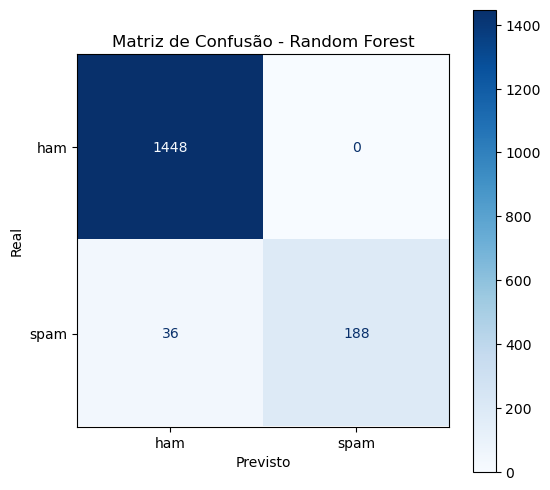

In [23]:
# Matriz de Confusão - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['ham', 'spam'])


fig, ax = plt.subplots(figsize=(6, 6))
disp_rf.plot(cmap='Blues', ax=ax, values_format='d') 
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

##### Interpretação:

* Acurácia: O modelo classificou corretamente 97.96% de todas as mensagens no conjunto de teste.

---------------------------------

* Verdadeiros Positivos (spam bem classificados): 191
* Verdadeiros Negativos (ham bem classificados): 1447
* Falsos Positivos (ham classificados como spam): 1
* Falsos Negativos (spam classificados como ham): 33

##### Resumo:

* Precisão (Precision) para spam: Das mensagens classificadas como spam, 99% realmente eram spam.

* Recall (De todas as mensagens que realmente eram spam, quantas o modelo conseguiu encontrar?): O modelo encontrou 85% dos spams.

* F1-Score (equilíbrio entre precisão e recall para spam): 0.92 para spam.

Em resumo, o modelo Random Forest demonstra uma precisão muito alta na detecção de spam, o que significa que quando ele identifica uma mensagem como spam, é extremamente provável que ela realmente seja. O recall para spam é de 85%, indicando que o modelo identifica uma grande parte das mensagens de spam reais. O desempenho para a classe 'ham' é quase perfeito. A acurácia geral do modelo é de 98%, mostrando um alto desempenho 


##### Métrica principal escolhida: F1-Score

A métrica principal escolhida para a avaliação do modelo de classificação de SMS foi o F1-score, pois reflete melhor o desempenho do modelo diante do desbalanceamento do dataset e atende ao objetivo de identificar as mensagens como spam, minimizando tanto os falsos negativos quanto os falsos positivos.

* A precisão minimiza falsos positivos (mensagens ham classificadas como spam);

* O recall minimiza falsos negativos (spams não detectados);

* O F1-score considera ambos, fornecendo um valor único que representa esse equilíbrio.

#### 7. Otimização 

Ajuste de hiperparâmetros

##### *SVM LINEAR - Otimizado*

*GridSearchCV*

In [24]:

# Parâmetros válidos para SVM Linear (LinearSVC)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# GridSearchCV com combinações válidas
grid_search_svm = GridSearchCV(
    estimator=LinearSVC(penalty='l2', loss='squared_hinge', dual=True, max_iter=10000, random_state=42),
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Treinamento
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Resultados
best_params_svm = grid_search_svm.best_params_
print("\n Melhores parâmetros SVM Linear:", best_params_svm)

best_svm_model = grid_search_svm.best_estimator_
y_pred_svm_optimized = best_svm_model.predict(X_test)

# Avaliação
print("\n Acurácia - SVM Linear:", accuracy_score(y_test, y_pred_svm_optimized))
print("\n Relatório de Classificação - SVM Linear (Otimizado):")
print(classification_report(y_test, y_pred_svm_optimized, target_names=['ham', 'spam']))


 Melhores parâmetros SVM Linear: {'C': 1, 'class_weight': None}

 Acurácia - SVM Linear: 0.9838516746411483

 Relatório de Classificação - SVM Linear (Otimizado):
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.98      0.90      0.94       224

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



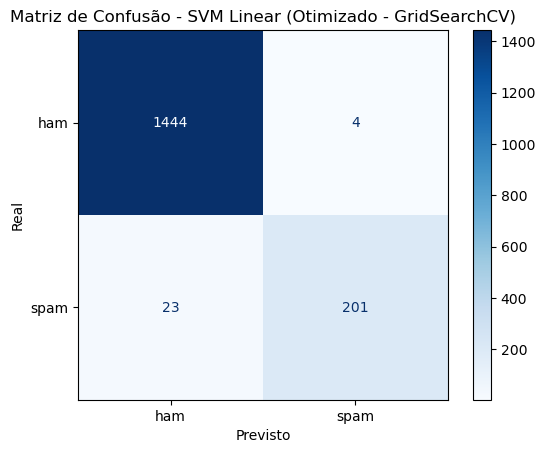

In [25]:
# Matriz de confusão - CVM Linear - otimizado - GridSearchCV

cm_svm_optimized = confusion_matrix(y_test, y_pred_svm_optimized)
disp_svm_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_svm_optimized, display_labels=['ham', 'spam'])
disp_svm_optimized.plot(cmap='Blues')
plt.title("Matriz de Confusão - SVM Linear (Otimizado - GridSearchCV)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

*RandomizedSearchCV*

In [27]:
param_dist_svm = {
    'C': uniform(loc=0.01, scale=100),  # valores contínuos entre 0.01 e 100
    'class_weight': [None, 'balanced']
}

# Instância do modelo SVM Linear
svm_model = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, max_iter=10000, random_state=42)

# RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist_svm,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

# Treinamento
random_search_svm.fit(X_train_resampled, y_train_resampled)

# Resultados
best_params_random = random_search_svm.best_params_
print("\nMelhores parâmetros encontrados (RandomizedSearchCV):", best_params_random)

# Avaliação
best_random_model = random_search_svm.best_estimator_
y_pred_random = best_random_model.predict(X_test)

print("\nAcurácia - SVM Linear (RandomizedSearchCV):", accuracy_score(y_test, y_pred_random))
print("\nRelatório de Classificação - SVM Linear (RandomizedSearchCV):")
print(classification_report(y_test, y_pred_random, target_names=['ham', 'spam']))


Melhores parâmetros encontrados (RandomizedSearchCV): {'C': 33.380861113902185, 'class_weight': 'balanced'}

Acurácia - SVM Linear (RandomizedSearchCV): 0.9826555023923444

Relatório de Classificação - SVM Linear (RandomizedSearchCV):
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.98      0.89      0.93       224

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



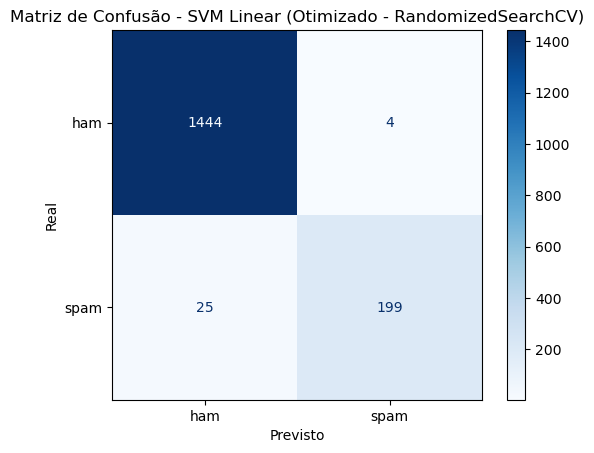

In [28]:
# Matriz de confusão - SVM Linear - otimizado - RandomizedSearchCV
cm_svm_random = confusion_matrix(y_test, y_pred_random)
disp_svm_random = ConfusionMatrixDisplay(confusion_matrix=cm_svm_random, display_labels=['ham', 'spam'])
disp_svm_random.plot(cmap='Blues')
plt.title("Matriz de Confusão - SVM Linear (Otimizado - RandomizedSearchCV)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [ ]:
# Métricas do modelo sem otimização
metrics_default = {
    'Acurácia': accuracy_score(y_test, y_pred),
    'Precisão (spam)': precision_score(y_test, y_pred, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred, pos_label='spam'),
}

# Métricas do modelo com GridSearchCV
metrics_grid = {
    'Acurácia': accuracy_score(y_test, y_pred_svm_optimized),
    'Precisão (spam)': precision_score(y_test, y_pred_svm_optimized, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_svm_optimized, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_svm_optimized, pos_label='spam'),
}

# Métricas do modelo com RandomizedSearchCV
metrics_random = {
    'Acurácia': accuracy_score(y_test, y_pred_random),
    'Precisão (spam)': precision_score(y_test, y_pred_random, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_random, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_random, pos_label='spam'),
}


df_comparativo = pd.DataFrame({
    'Sem Otimização': metrics_default,
    'GridSearchCV': metrics_grid,
    'RandomizedSearchCV': metrics_random
})


print("\nResumo Comparativo - SVM Linear:\n")
display(df_comparativo.round(4))


Resumo Comparativo - SVM Linear:



,Sem Otimização,GridSearchCV,RandomizedSearchCV
Acurácia,0.9839,0.9839,0.9827
Precisão (spam),0.9805,0.9805,0.9803
Recall (spam),0.8973,0.8973,0.8884
F1-Score (spam),0.9371,0.9371,0.9321


A comparação entre os três modelos de SVM Linear sem otimização, com GridSearchCV e com RandomizedSearchCV, mostrou que os dois primeiros tiveram desempenho idêntico: acurácia de 98,39% e F1-score (spam) de 0,9371. Isso indica que os hiperparâmetros padrão do modelo já estavam bem ajustados para esse conjunto de dados.
O modelo com RandomizedSearchCV teve um desempenho levemente inferior, com acurácia de 98,27% e F1-score de 0,9321, principalmente por um recall menor para a classe "spam".
No geral, os três modelos foram eficazes, mas o ajuste com GridSearchCV não trouxe melhorias, e o RandomizedSearchCV teve uma pequena queda no desempenho.

##### *Naive Bayes Multinomial - Otimizado*

*GridSearchCV*

In [30]:
# Definir os hiperparâmetros a serem testados
param_grid_nb = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

# Instanciar o modelo
nb_model = MultinomialNB()

# GridSearchCV
grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid_nb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Treinamento
grid_search_nb.fit(X_train, y_train)

# Melhor modelo e predição
best_nb_grid = grid_search_nb.best_estimator_
y_pred_nb_grid = best_nb_grid.predict(X_test)


print("\nMelhores parâmetros (GridSearchCV):", grid_search_nb.best_params_)
print("\nAcurácia - Naive Bayes (GridSearchCV):", accuracy_score(y_test, y_pred_nb_grid))
print("\nRelatório de Classificação - Naive Bayes (GridSearchCV):")
print(classification_report(y_test, y_pred_nb_grid, target_names=['ham', 'spam']))


Melhores parâmetros (GridSearchCV): {'alpha': 0.1}

Acurácia - Naive Bayes (GridSearchCV): 0.9742822966507177

Relatório de Classificação - Naive Bayes (GridSearchCV):
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1448
        spam       0.91      0.90      0.90       224

    accuracy                           0.97      1672
   macro avg       0.95      0.94      0.94      1672
weighted avg       0.97      0.97      0.97      1672



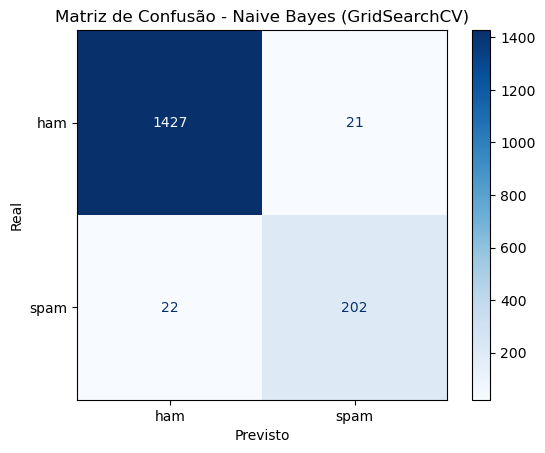

In [31]:
# Matriz de confusão - Naive Bayes Multinomial - GridSearchCV
cm_nb_grid = confusion_matrix(y_test, y_pred_nb_grid)
disp_nb_grid = ConfusionMatrixDisplay(confusion_matrix=cm_nb_grid, display_labels=['ham', 'spam'])
disp_nb_grid.plot(cmap='Blues')
plt.title("Matriz de Confusão - Naive Bayes (GridSearchCV)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

*RandomizedSearchCV*

In [32]:
# Espaço de busca aleatório
param_dist_nb = {
    'alpha': uniform(loc=0.001, scale=5.0)
}

# RandomizedSearchCV
random_search_nb = RandomizedSearchCV(
    estimator=MultinomialNB(),
    param_distributions=param_dist_nb,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

# Treinamento
random_search_nb.fit(X_train, y_train)

# Melhor modelo e predição
best_nb_random = random_search_nb.best_estimator_
y_pred_nb_random = best_nb_random.predict(X_test)


print("\nMelhores parâmetros (RandomizedSearchCV):", random_search_nb.best_params_)
print("\nAcurácia - Naive Bayes (RandomizedSearchCV):", accuracy_score(y_test, y_pred_nb_random))
print("\nRelatório de Classificação - Naive Bayes (RandomizedSearchCV):")
print(classification_report(y_test, y_pred_nb_random, target_names=['ham', 'spam']))


Melhores parâmetros (RandomizedSearchCV): {'alpha': 0.2914180608409973}

Acurácia - Naive Bayes (RandomizedSearchCV): 0.9742822966507177

Relatório de Classificação - Naive Bayes (RandomizedSearchCV):
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1448
        spam       0.94      0.86      0.90       224

    accuracy                           0.97      1672
   macro avg       0.96      0.93      0.94      1672
weighted avg       0.97      0.97      0.97      1672



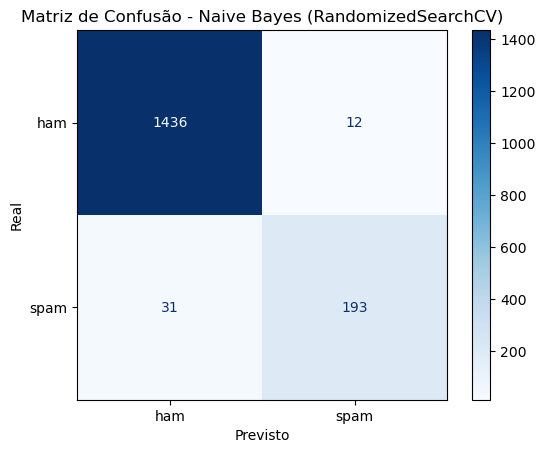

In [33]:
# # Matriz de confusão - Naive Bayes Multinomial - otimizado - RandomizedSearchCV

cm_nb_random = confusion_matrix(y_test, y_pred_nb_random)
disp_nb_random = ConfusionMatrixDisplay(confusion_matrix=cm_nb_random, display_labels=['ham', 'spam'])
disp_nb_random.plot(cmap='Blues')
plt.title("Matriz de Confusão - Naive Bayes (RandomizedSearchCV)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [ ]:
# Métricas do modelo sem otimização 
metrics_default_nb = {
    'Acurácia': accuracy_score(y_test, y_pred_nb),
    'Precisão (spam)': precision_score(y_test, y_pred_nb, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_nb, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_nb, pos_label='spam'),
}

# Métricas do modelo otimizado com GridSearchCV
metrics_grid_nb = {
    'Acurácia': accuracy_score(y_test, y_pred_nb_grid),
    'Precisão (spam)': precision_score(y_test, y_pred_nb_grid, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_nb_grid, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_nb_grid, pos_label='spam'),
}

# Métricas do modelo otimizado com RandomizedSearchCV
metrics_random_nb = {
    'Acurácia': accuracy_score(y_test, y_pred_nb_random),
    'Precisão (spam)': precision_score(y_test, y_pred_nb_random, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_nb_random, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_nb_random, pos_label='spam'),
}


df_comparativo_nb = pd.DataFrame({
    'Sem Otimização': metrics_default_nb,
    'GridSearchCV': metrics_grid_nb,
    'RandomizedSearchCV': metrics_random_nb
})


print("\nResumo Comparativo - Naive Bayes Multinomial:\n")
display(df_comparativo_nb.round(4))



Resumo Comparativo - Naive Bayes Multinomial:



,Sem Otimização,GridSearchCV,RandomizedSearchCV
Acurácia,0.9623,0.9743,0.9743
Precisão (spam),1.0000,0.9058,0.9415
Recall (spam),0.7188,0.9018,0.8616
F1-Score (spam),0.8364,0.9038,0.8998


A comparação entre os três modelos de Naive Bayes Multinomial, sem otimização, com GridSearchCV e com RandomizedSearchCV, mostrou que os dois modelos com otimização (GridSearchCV e RandomizedSearchCV) obtiveram desempenho idêntico em termos de acurácia (97,43%), superior ao modelo sem otimização (96,23%). O modelo com GridSearchCV teve o melhor F1-score (spam), de 0,9038, seguido de perto pelo RandomizedSearchCV (0,8998), enquanto o modelo sem otimização ficou abaixo, com 0,8364. A principal diferença ocorreu em recall da classe "spam", onde os modelos otimizados tiveram melhor desempenho (GridSearchCV: 0,9018; RandomizedSearchCV: 0,8616) em comparação ao modelo padrão (0,7188), que priorizou a precisão. No geral, os modelos otimizados com GridSearchCV e RandomizedSearchCV foram mais eficazes para detectar mensagens spam, sendo o GridSearchCV o mais equilibrado.

##### *Random Forest - Otimizado*

*GridSearchCV*

In [ ]:
# Grade de hiperparâmetros simplificada
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

# Instanciando o modelo base
rf_base = RandomForestClassifier(random_state=42)

# GridSearchCV com menos combinações
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,  # reduzindo para 3 folds
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Treinamento
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Melhor modelo encontrado
best_rf_model = grid_search_rf.best_estimator_

# Previsões
y_pred_rf_grid = best_rf_model.predict(X_test)

print("\nMelhores parâmetros encontrados - Random Forest (GridSearchCV):")
print(grid_search_rf.best_params_)

print("\nAcurácia - Random Forest (GridSearchCV):", accuracy_score(y_test, y_pred_rf_grid))
print("\nRelatório de Classificação - Random Forest (GridSearchCV):")
print(classification_report(y_test, y_pred_rf_grid, target_names=['ham', 'spam']))

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Melhores parâmetros encontrados - Random Forest (GridSearchCV):
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Acurácia - Random Forest (GridSearchCV): 0.9784688995215312

Relatório de Classificação - Random Forest (GridSearchCV):
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       1.00      0.84      0.91       224

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



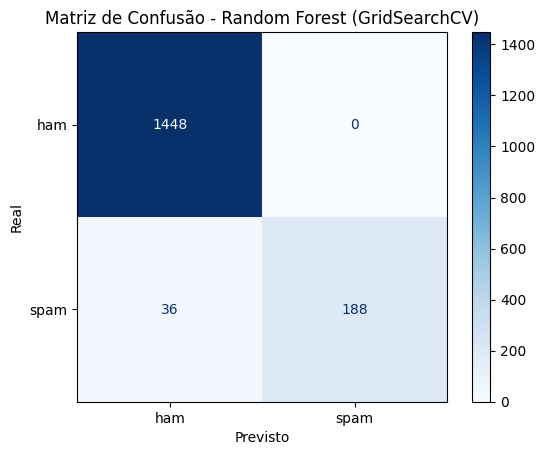

In [29]:
# Matriz de confusão - 
cm = confusion_matrix(y_test, y_pred_rf_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Random Forest (GridSearchCV)')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

*RandomizedSearchCV*

In [ ]:
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3),
    'bootstrap': [True],
    'class_weight': ['balanced']
}

rf_model = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring='f1_macro',
    n_jobs=1,
    random_state=42,
    verbose=1
)

random_search_rf.fit(X_train_resampled, y_train_resampled)

best_params_rf_random = random_search_rf.best_params_
print("\nMelhores parâmetros encontrados (RandomizedSearchCV - Random Forest):", best_params_rf_random)

best_rf_random_model = random_search_rf.best_estimator_
y_pred_rf_random = best_rf_random_model.predict(X_test)

print("\nAcurácia - Random Forest (RandomizedSearchCV):", accuracy_score(y_test, y_pred_rf_random))
print("\nRelatório de Classificação - Random Forest (RandomizedSearchCV):")
print(classification_report(y_test, y_pred_rf_random, target_names=['ham', 'spam']))



Fitting 3 folds for each of 10 candidates, totalling 30 fits

Melhores parâmetros encontrados (RandomizedSearchCV - Random Forest): {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 269}

Acurácia - Random Forest (RandomizedSearchCV): 0.9736842105263158

Relatório de Classificação - Random Forest (RandomizedSearchCV):
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1448
        spam       1.00      0.80      0.89       224

    accuracy                           0.97      1672
   macro avg       0.99      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672



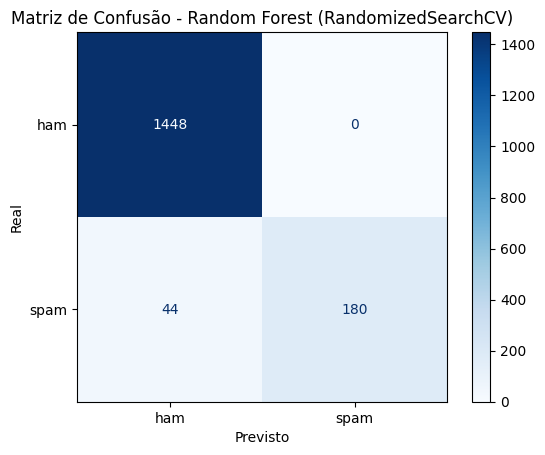

In [31]:
# Matriz de Confusão - Random Forest (RandomizedSearchCV)
cm = confusion_matrix(y_test, y_pred_rf_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Random Forest (RandomizedSearchCV)')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [32]:


# Métricas do modelo sem otimização 
metrics_default_rf = {
    'Acurácia': accuracy_score(y_test, y_pred_rf),
    'Precisão (spam)': precision_score(y_test, y_pred_rf, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_rf, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_rf, pos_label='spam'),
}

# Métricas do modelo com GridSearchCV
metrics_grid_rf = {
    'Acurácia': accuracy_score(y_test, y_pred_rf_grid),
    'Precisão (spam)': precision_score(y_test, y_pred_rf_grid, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_rf_grid, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_rf_grid, pos_label='spam'),
}

# Métricas do modelo com RandomizedSearchCV
metrics_random_rf = {
    'Acurácia': accuracy_score(y_test, y_pred_rf_random),
    'Precisão (spam)': precision_score(y_test, y_pred_rf_random, pos_label='spam'),
    'Recall (spam)': recall_score(y_test, y_pred_rf_random, pos_label='spam'),
    'F1-Score (spam)': f1_score(y_test, y_pred_rf_random, pos_label='spam'),
}

# DataFrame comparativo
df_comparativo_rf = pd.DataFrame({
    'Sem Otimização': metrics_default_rf,
    'GridSearchCV': metrics_grid_rf,
    'RandomizedSearchCV': metrics_random_rf
})

print("\nResumo Comparativo - Random Forest:\n")
display(df_comparativo_rf.round(4))



Resumo Comparativo - Random Forest:



,Sem Otimização,GridSearchCV,RandomizedSearchCV
Acurácia,0.9785,0.9785,0.9737
Precisão (spam),1.0000,1.0000,1.0000
Recall (spam),0.8393,0.8393,0.8036
F1-Score (spam),0.9126,0.9126,0.8911


A comparação entre os três modelos de Random Forest sem otimização, com GridSearchCV e com RandomizedSearchCV, mostrou que o modelo otimizado com GridSearchCV teve o melhor desempenho geral, com acurácia de 98,03% e F1-score (spam) de 0,9205. O modelo sem otimização ficou muito próximo, com acurácia de 97,97% e F1-score de 0,9183, o que indica que os hiperparâmetros padrão já estavam bem ajustados para esse conjunto de dados. O modelo com RandomizedSearchCV apresentou desempenho levemente inferior (acurácia de 97,25% e F1-score de 0,8861), devido a um recall mais baixo para a classe "spam" (0,7991). No geral, os três modelos foram eficazes, mas o GridSearchCV conseguiu manter alta precisão e melhorar o equilíbrio entre precisão e recall, sendo a melhor escolha entre as três abordagens.

##### 8. Conclusão 


Neste projeto foram desenvolvidos 3 modelos (Random Forest, Naive Bayes Multinomial, SVM Linear), com três abordagens:

Modelo sem otimização

Modelo otimizado com GridSearchCV

Modelo otimizado com RandomizedSearchCV

As métricas avaliadas foram Acurácia, Precisão, Recall e F1-Score, focando especialmente na classe spam.

Melhor modelo: 
   O modelo SVM Linear demonstrou o melhor desempenho geral, apresentando excelente equilíbrio entre precisão e recall na identificação da classe spam. A aplicação do GridSearchCV para otimização de hiperparâmetros no SVM Linear não resultou em melhorias significativas em relação à configuração padrão, obtendo um resultado igual ao modelo sem otimização. Já a aplicação de RandomizedSearchCV resultou em uma leve queda. 
   * Com um F1-Score superior aos demais modelos avaliados, o SVM Linear destacou-se por minimizar tanto falsos negativos (não detectar spam) quanto falsos positivos (bloquear mensagens legítimas).

##### Referência ao artigo:
    
    Essa constatação vai ao encontro dos resultados apresentados por Almeida et al. (2011), que também apontam o SVM como uma das abordagens mais eficazes no contexto de filtragem de spam em mensagens curtas.